### Checking "Half-your-age-plus-seven rule" based on reddit posts

Code/data for /r/dataisbeautiful post

In [1]:
%matplotlib inline
import json
import pandas as pd
import lzma
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import gzip
import glob
import re

In [2]:
# pip3 install --user git+git://github.com/aminnj/yahist.git#egg=yahist -U
from yahist.utils import set_default_style
from yahist import Hist1D, Hist2D
set_default_style()

In [30]:
data = []
fnames = glob.glob("relationship_advice.jsonl.gz")
for fname in tqdm(fnames, position=0):
    with gzip.open(fname, mode="rt") as fh:
        iline = 0
        for line in tqdm(fh, position=1):
            iline += 1
            js = json.loads(line)
            if js["author"] == "[deleted]": continue
            if not js["is_self"]: continue
            data.append(js)
            if iline > 385000: break
            
dfc = pd.DataFrame(data)
del data

print(dfc.shape, dfc.columns)



(205714, 105) Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'brand_safe', 'contest_mode', 'created_utc', 'distinguished', 'domain',
       'edited',
       ...
       'quarantine', 'subreddit_name_prefixed', 'author_patreon_flair',
       'gildings', 'is_robot_indexable', 'media_metadata', 'all_awardings',
       'total_awards_received', 'allow_live_comments', 'discussion_type'],
      dtype='object', length=105)


In [31]:
dfc["subreddit"].value_counts()

relationship_advice    205714
Name: subreddit, dtype: int64

In [32]:
def parse_title(s):
    # NOTE: Yes, this is the kind of code that only makes sense while you're writing it.
    # - Parse specific, but common pattern with two sets of [] or () referring to age and gender
    # - Require exactly two, and only one of them must be first person (i/me/my)
    # - Return subject,age,gender for first and second person. Ordering is such that
    # the first person is the OP
    subjects = re.findall("([\w\'']+)[\W]?[\(\[][0-9][0-9][\/ ]?[MmFf][\)\]]", s)
    if not len(subjects) == 2: return {}
    genders = re.findall("[\(\[][0-9][0-9][\/ ]?([MmFf])[\)\]]", s)
    if not len(genders) == 2: return {}
    ages = re.findall("[\(\[]([0-9][0-9])[\/ ]?[MmFf][\)\]]", s)
    if not len(ages) == 2: return {}
    ages = [int(x) for x in ages]
    genders = [x.upper() for x in genders]
    subjects = [x.upper() for x in subjects]
    subject1, subject2 = subjects
    gender1, gender2 = genders
    age1, age2 = ages
    iposter = -1 # 1 if first set is the OP, otherwise 2
    
    firstpersonwords = ["I","ME","MY","I'M"]
    for word in firstpersonwords:
        if subject1 == word and subject2 != word: 
            iposter = 1
            break
        if subject1 != word and subject2 == word: 
            iposter = 2
            break
    if iposter == -1: return {}
    
    if iposter == 2:
        subject1, subject2 = subject2, subject1
        gender1, gender2 = gender2, gender1
        age1, age2 = age2, age1
        
    return (dict(
        subject1 = subject1,
        subject2 = subject2,
        age1 = age1,
        age2 = age2,
        gender1 = gender1,
        gender2 = gender2,
    ))


tests = [
    "My [26 f] boyfriend [28/m] didn't get me a t-rex",
    "I [16 m] got my gf [18F] a dinosaur",
    "Me (16 m) is tired of my wife [18F]",
    "SO (29M) stole my [18F] dinosaurs",
    "My friend (26/F) is a dinosaur, and I'm (23/F) worried about her"
]
for x in map(parse_title,tests):
    print(x)

{'subject1': 'MY', 'subject2': 'BOYFRIEND', 'age1': 26, 'age2': 28, 'gender1': 'F', 'gender2': 'M'}
{'subject1': 'I', 'subject2': 'GF', 'age1': 16, 'age2': 18, 'gender1': 'M', 'gender2': 'F'}
{'subject1': 'ME', 'subject2': 'WIFE', 'age1': 16, 'age2': 18, 'gender1': 'M', 'gender2': 'F'}
{'subject1': 'MY', 'subject2': 'SO', 'age1': 18, 'age2': 29, 'gender1': 'F', 'gender2': 'M'}
{'subject1': "I'M", 'subject2': 'FRIEND', 'age1': 23, 'age2': 26, 'gender1': 'F', 'gender2': 'F'}


In [33]:
tokeep = (
    "author,created_utc,"
    "gilded,link_flair_text,"
    "num_comments,num_crossposts,over_18,permalink,"
    "retrieved_on,score,"
    "selftext,subreddit,"
    "title,url,"
    "subreddit_subscribers,"
    "removed,hidden,locked,"
)
dfc = dfc.drop(dfc.columns.difference(tokeep.split(",")), axis=1)

# Add columns of parsed info
extra = pd.DataFrame(dfc["title"].map(parse_title).values.tolist())
dfc = pd.concat([dfc,extra],axis=1)

In [34]:
print(dfc.shape,"original")

# we must have identified the two subjects in the title
dfc = dfc.dropna(subset=["subject1","subject2"])
print(dfc.shape,"parsed_title")

# first pass at cleaning up relatives/parents/friends/etc
dfc = dfc[(dfc["link_flair_text"] != "Non-Romantic") & (dfc["link_flair_text"] != "Personal issues")]
print(dfc.shape,"not Non-Romantic or Personal issues")

# I'm not a homophobe. some people just can't type properly. in the selftext, they'll say
# "oops, title is a typo, I meant...". sigh.
dfc = dfc[dfc["gender1"] != dfc["gender2"]]
print(dfc.shape,"MF/FM")

# retrieve date is usually a month after creation, so one could do analysis with comments,
# as the post is basically "complete" at that point
dfc["created_utc"] = pd.to_datetime(dfc["created_utc"], unit="s")
dfc["retrieved_on"] = pd.to_datetime(dfc["retrieved_on"], unit="s")

# 1,2 ordering is such that 1 is OP
# for convenience, separate age by M,F as well
dfc["age1"] = dfc["age1"].astype(int)
dfc["age2"] = dfc["age2"].astype(int)
dfc["ageM"] = (dfc["age1"]*(dfc["gender1"]=="M") + dfc["age2"]*(dfc["gender2"]=="M")).astype(int)
dfc["ageF"] = (dfc["age1"]*(dfc["gender1"]=="F") + dfc["age2"]*(dfc["gender2"]=="F")).astype(int)

# small fraction of people make several rapid fire submissions with different ages,
# maybe they are time travelers, but I don't care
dfc = dfc.drop_duplicates("author")
print(dfc.shape,"unique authors")

# more targeted method to sure we're not getting relatives/parents/grandparents/etc
partnerwords = [
    "BOYFRIEND","GIRLFRIEND","GF","BF","HUSBAND","WIFE","PARTNER","SO",
    "GIRL","GUY","FIANCE","FIANCÉ", "BOYFRIEND'S", "GIRLFRIEND'S", "FRIEND", 
    "MY", "HIM", "HER", "WITH",
]
dfc = dfc[dfc["subject2"].isin(partnerwords)]
print(dfc.shape,"partner words")

# ignore deleted posts (either by OP or by admins).
dfc = dfc[dfc["selftext"]!="[removed]"]
print(dfc.shape,"not removed")

dfc = dfc.reset_index(drop=True)

(205714, 23) original
(45016, 23) parsed_title
(45016, 23) not Non-Romantic or Personal issues
(40840, 23) MF/FM
(36693, 25) unique authors
(28450, 25) partner words
(27850, 25) not removed


In [35]:
dfc["gender1"].str.cat(dfc["gender2"]).value_counts()

MF    16081
FM    11769
Name: gender1, dtype: int64

In [36]:
(dfc[["title","subject1","subject2","gender1","gender2","age1","age2"]]
 .dropna()
 .head(10)
 .style.set_properties(subset=["title"], width="600px")
)

,title,subject1,subject2,gender1,gender2,age1,age2
0,Me (25/M) and my girlfriend (20/F) have been dating but my friends don’t like her,ME,GIRLFRIEND,M,F,25,20
1,I (22/F) don't know how to cope with my boyfriend's (21/M) mental illness.,I,BOYFRIEND'S,F,M,22,21
2,new gf [25/f] is hard to please in bed? how do I [28m] focus on it without focusing on it?,I,GF,M,F,28,25
3,I (21F) have a boyfriend (30M) but I want a girlfriend,I,BOYFRIEND,F,M,21,30
4,Should I [27/m] break up with my gf [28/f] ?,I,GF,M,F,27,28
5,I [20/m] feel like my girlfriend [19/f] is getting more distant with me. Any advice?,I,GIRLFRIEND,M,F,20,19
6,I[32f] feel like my husband[29m] is a stranger. I'm starting to feel trapped...,I,HUSBAND,F,M,32,29
7,"I [32M] broke up with my girlfriend [24F] of 2 years, and I'm heartbroken about it.",I,GIRLFRIEND,M,F,32,24
8,My girlfriend [41/F] wants me [23/M] to follow her literally everywhere she goes.,ME,GIRLFRIEND,M,F,23,41
9,My [25F] boyfriend [25M] of 2 years is bothered by the fact that he's only been with two women but doesn't want to leave me,MY,BOYFRIEND,F,M,25,25


In [13]:
(dfc.drop(columns=["selftext"])
 .to_parquet("dfc.parquet")
)

In [14]:
dfc = pd.read_parquet("dfc.parquet")

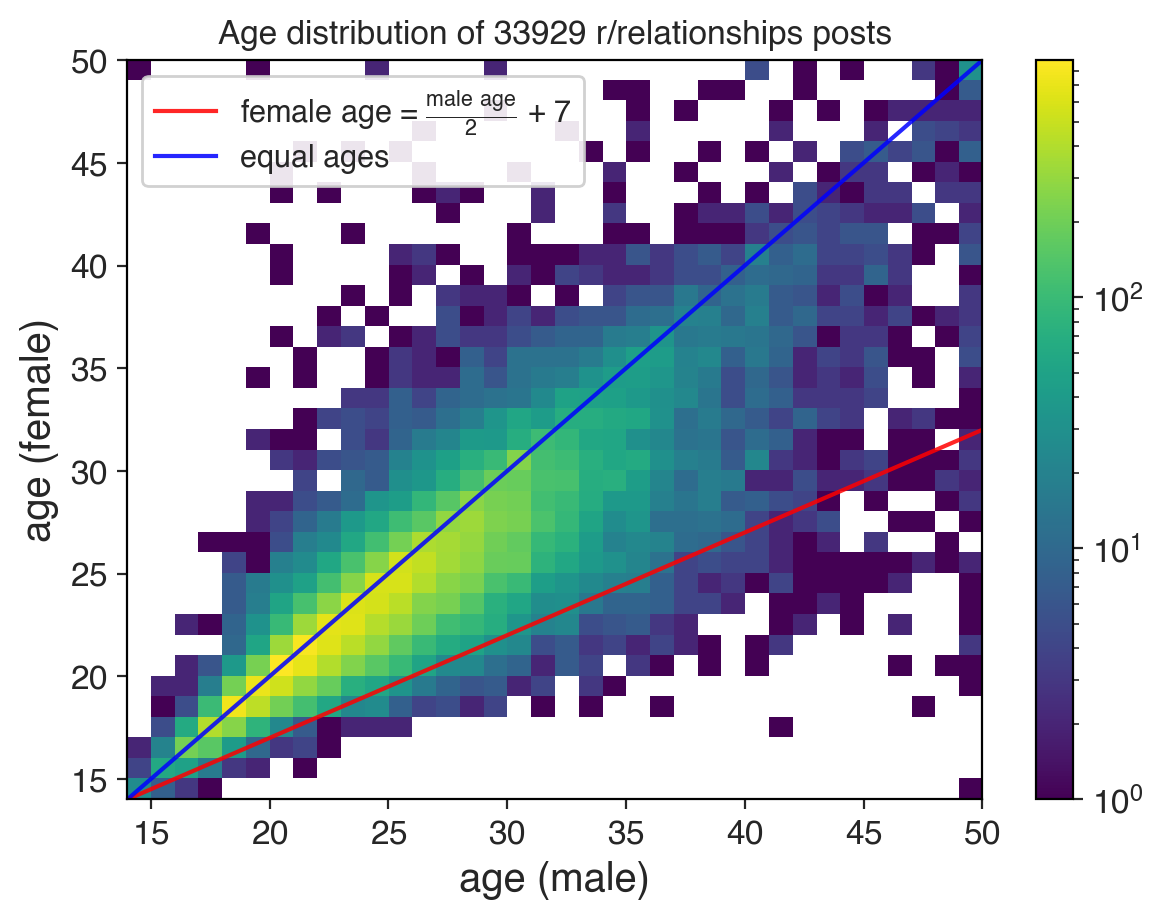

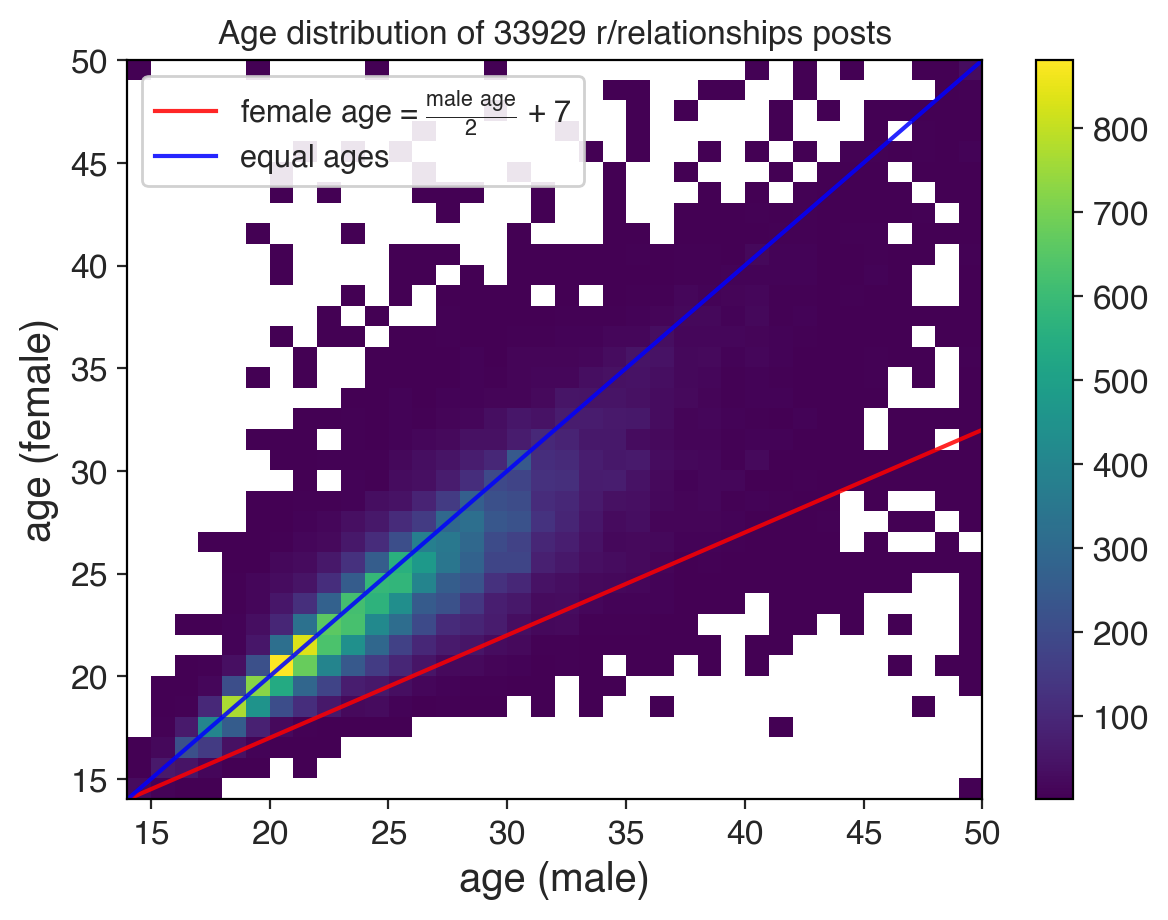

In [15]:
df = dfc

for logz in [True,False]:

    fig, ax = plt.subplots()
    bins = np.linspace(14,50,(50-14+1)//1)
    h = Hist2D(df[["ageM","ageF"]].values, bins=bins)
    h.plot(ax=ax, cmap="viridis",logz=logz)
    ax.set_xlabel("age (male)")
    ax.set_ylabel("age (female)")

    ax.plot(bins,bins/2.+7, color="r", label=r"female age = $\mathregular{\frac{male\ age}{2}}$ + 7", alpha=0.85)
    ax.plot(bins,bins, color="b", label="equal ages", alpha=0.85)

    ax.legend(framealpha=0.9)

    ax.set_title(f"Age distribution of {len(df)} r/relationships posts")

In [24]:
# 80% satisfy the "rule"
import duckdb
duckdb.sql("""
select avg((ageF between ageM/2+7 and ageM)::int)
from df
""").df()

,avg(CAST((ageF BETWEEN ((ageM / 2) + 7) AND ageM) AS INTEGER))
0,0.807687
